## 목차
### 1. Library Import
### 2. 학습데이터 생성
### 3. Light-gbm 모델 훈련
### 4. 교차 검증 점수 확인
### 5. 제출 파일 생성

# 1. Library Import

In [3]:
!pip install pycaret

     |████████████████████████████████| 256kB 5.4MB/s 
     |████████████████████████████████| 102kB 4.8MB/s 
     |████████████████████████████████| 157.5MB 92kB/s 
     |████████████████████████████████| 14.2MB 345kB/s 
     |████████████████████████████████| 174kB 35.1MB/s 
     |████████████████████████████████| 245kB 38.1MB/s 
     |████████████████████████████████| 1.6MB 36.2MB/s 
     |████████████████████████████████| 276kB 51.5MB/s 
     |████████████████████████████████| 6.8MB 46.3MB/s 
     |████████████████████████████████| 65.8MB 60kB/s 
     |████████████████████████████████| 1.8MB 45.3MB/s 
     |████████████████████████████████| 2.1MB 34.2MB/s 
     |████████████████████████████████| 1.1MB 28.0MB/s 
     |████████████████████████████████| 163kB 36.6MB/s 
     |████████████████████████████████| 153kB 43.6MB/s 
     |████████████████████████████████| 348kB 44.8MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 

In [4]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

PATH = '/content/drive/MyDrive/Colab Notebooks/데이콘_lg/'

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 학습 데이터 생성

2.0 train_qual

In [5]:
train_qual  = pd.read_csv(PATH+'train_quality_data.csv', thousands = ',')
display(train_qual.head())

time  user_id       fwver  quality_0  quality_1  quality_2  \
0  20201129090000    10000  05.15.2138        0.0          0        0.0   
1  20201129090000    10000  05.15.2138        0.0          0        0.0   
2  20201129090000    10000  05.15.2138        0.0          0        0.0   
3  20201129090000    10000  05.15.2138        0.0          0        0.0   
4  20201129090000    10000  05.15.2138        0.0          0        0.0   

   quality_3  quality_4  quality_5  quality_6  quality_7  quality_8  \
0          0          0        0.0          0          0          0   
1          0          0        0.0          0          0          0   
2          0          0        0.0          0          0          0   
3          0          0        0.0          0          0          0   
4          0          0        0.0          0          0          0   

   quality_9  quality_10  quality_11  quality_12  
0          0           4           0           0  
1          0           4           0           0  
2          0           4           0           0  
3          0           4           0           0  
4          0           4           0           0

In [6]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  float64
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  int64  
 11  quality_8   828624 non-null  int64  
 12  quality_9   828624 non-null  int64  
 13  quality_10  828624 non-null  int64  
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(3), int64(12), object(1)
memory usage: 101.2+ MB


In [7]:
train_qual['quality_0'][(train_qual['quality_0'] >= 5) & (train_qual['quality_0'] <= 9)] = 5
train_qual['quality_0'][(train_qual['quality_0'] >= 10) & (train_qual['quality_0'] <= 99)] = 6
train_qual['quality_0'][(train_qual['quality_0'] >= 100) & (train_qual['quality_0'] <= 999)] = 7
train_qual['quality_0'][(train_qual['quality_0'] >= 1000) & (train_qual['quality_0'] <= 9999)] = 8
train_qual['quality_0'][(train_qual['quality_0'] >= 10000) & (train_qual['quality_0'] <= 99999)] = 9
train_qual['quality_0'][train_qual['quality_0'] >= 100000] = 10
train_qual['quality_0'][train_qual['quality_0'].isnull()] = 11
train_qual['quality_0'][train_qual['quality_0'] == -1] = 12
train_qual['quality_0'] = train_qual['quality_0'].astype(int)

print(train_qual.quality_0.value_counts().sort_index())
print(train_qual.quality_0.value_counts().sort_index().sum())

0     542790
1       2097
2       1252
3        518
4        410
5       1623
6       3445
7       1012
8        172
9         39
10         6
11    144432
12    130828
Name: quality_0, dtype: int64
828624


In [8]:
train_qual['quality_1'][(train_qual['quality_1'] >= 5) & (train_qual['quality_1'] <= 9)] = 5
train_qual['quality_1'][(train_qual['quality_1'] >= 10) & (train_qual['quality_1'] <= 99)] = 6
train_qual['quality_1'][(train_qual['quality_1'] >= 100) & (train_qual['quality_1'] <= 999)] = 7
train_qual['quality_1'][(train_qual['quality_1'] >= 1000)] = 8
train_qual['quality_1'][train_qual['quality_1'].isnull()] = 9
train_qual['quality_1'][train_qual['quality_1'] == -1] = 10

print(train_qual.quality_1.value_counts().sort_index())
print(train_qual.quality_1.value_counts().sort_index().sum())

0     670270
1       2567
2       1140
3        391
4        202
5        316
6         81
7          8
10    153649
Name: quality_1, dtype: int64
828624


In [9]:
train_qual['quality_2'][(train_qual['quality_2'] >= 5) & (train_qual['quality_2'] <= 9)] = 5
train_qual['quality_2'][(train_qual['quality_2'] >= 10) & (train_qual['quality_2'] <= 99)] = 6
train_qual['quality_2'][(train_qual['quality_2'] >= 100) & (train_qual['quality_2'] <= 999)] = 7
train_qual['quality_2'][(train_qual['quality_2'] >= 1000) & (train_qual['quality_2'] <= 9999)] = 8
train_qual['quality_2'][(train_qual['quality_2'] >= 10000) & (train_qual['quality_2'] <= 99999)] = 9
train_qual['quality_2'][train_qual['quality_2'] >= 100000] = 10
train_qual['quality_2'][train_qual['quality_2'].isnull()] = 11
train_qual['quality_2'][train_qual['quality_2'] == -1] = 12
train_qual['quality_2'] = train_qual['quality_2'].astype(int)

print(train_qual.quality_2.value_counts().sort_index())
print(train_qual.quality_2.value_counts().sort_index().sum())

0     632469
1       2937
2       1073
3        580
4        455
5       1749
6       3561
7       1032
8        210
9         42
10        11
11     40113
12    144392
Name: quality_2, dtype: int64
828624


In [10]:
train_qual['quality_5'][(train_qual['quality_5'] >= 5) & (train_qual['quality_5'] <= 9)] = 5
train_qual['quality_5'][(train_qual['quality_5'] >= 10) & (train_qual['quality_5'] <= 99)] = 6
train_qual['quality_5'][(train_qual['quality_5'] >= 100) & (train_qual['quality_5'] <= 999)] = 7
train_qual['quality_5'][(train_qual['quality_5'] >= 1000) & (train_qual['quality_5'] <= 9999)] = 8
train_qual['quality_5'][(train_qual['quality_5'] >= 10000) & (train_qual['quality_5'] <= 99999)] = 9
train_qual['quality_5'][train_qual['quality_5'] >= 100000] = 10
train_qual['quality_5'][train_qual['quality_5'].isnull()] = 11
train_qual['quality_5'][train_qual['quality_5'] == -1] = 12
train_qual['quality_5'] = train_qual['quality_5'].astype(int)

print(train_qual.quality_5.value_counts().sort_index())
print(train_qual.quality_5.value_counts().sort_index().sum())

0     428096
1      56171
2      35978
3      21596
4      11204
5      29487
6      64444
7      22704
8       4631
9        872
10        67
11        20
12    153354
Name: quality_5, dtype: int64
828624


In [11]:
train_qual['quality_6'][(train_qual['quality_6'] >= 5) & (train_qual['quality_6'] <= 9)] = 5
train_qual['quality_6'][(train_qual['quality_6'] >= 10) & (train_qual['quality_6'] <= 99)] = 6
train_qual['quality_6'][(train_qual['quality_6'] >= 100) & (train_qual['quality_6'] <= 999)] = 7
train_qual['quality_6'][train_qual['quality_6'] == -1] = 8

print(train_qual.quality_6.value_counts().sort_index())
print(train_qual.quality_6.value_counts().sort_index().sum())

0    662217
1      1347
2       603
3       475
4       408
5      1698
6      4628
7      3717
8    153531
Name: quality_6, dtype: int64
828624


In [12]:
train_qual['quality_7'][(train_qual['quality_7'] >= 5) & (train_qual['quality_7'] <= 9)] = 5
train_qual['quality_7'][(train_qual['quality_7'] >= 10) & (train_qual['quality_7'] <= 99)] = 6
train_qual['quality_7'][(train_qual['quality_7'] >= 100) & (train_qual['quality_7'] <= 999)] = 7
train_qual['quality_7'][(train_qual['quality_7'] >= 1000) & (train_qual['quality_7'] <= 9999)] = 8
train_qual['quality_7'][train_qual['quality_7'] == -1] = 9


print(train_qual.quality_7.value_counts().sort_index())
print(train_qual.quality_7.value_counts().sort_index().sum())

0    757788
1      6768
2      3648
3      2568
4      2124
5      9552
6     29148
7     12240
8      4788
Name: quality_7, dtype: int64
828624


In [13]:
train_qual['quality_8'][(train_qual['quality_8'] >= 5) & (train_qual['quality_8'] <= 9)] = 5
train_qual['quality_8'][(train_qual['quality_8'] >= 10) & (train_qual['quality_8'] <= 99)] = 6
train_qual['quality_8'][(train_qual['quality_8'] >= 100) & (train_qual['quality_8'] <= 999)] = 7
train_qual['quality_8'][(train_qual['quality_8'] >= 1000) & (train_qual['quality_8'] <= 9999)] = 8
train_qual['quality_8'][(train_qual['quality_8'] >= 10000)] = 9
train_qual['quality_8'][train_qual['quality_8'] == -1] = 10


print(train_qual.quality_8.value_counts().sort_index())
print(train_qual.quality_8.value_counts().sort_index().sum())

0    787812
1     19104
2      8832
3      4020
4      2592
5      4416
6      1824
7        12
8        12
Name: quality_8, dtype: int64
828624


In [14]:
train_qual['quality_9'][(train_qual['quality_9'] >= 5) & (train_qual['quality_9'] <= 9)] = 5
train_qual['quality_9'][(train_qual['quality_9'] >= 10) & (train_qual['quality_9'] <= 99)] = 6
train_qual['quality_9'][(train_qual['quality_9'] >= 100) & (train_qual['quality_9'] <= 999)] = 7
train_qual['quality_9'][(train_qual['quality_9'] >= 1000) & (train_qual['quality_9'] <= 9999)] = 8
train_qual['quality_9'][(train_qual['quality_9'] >= 10000) & (train_qual['quality_9'] <= 99999)] = 9
train_qual['quality_9'][(train_qual['quality_9'] >= 100000) & (train_qual['quality_9'] <= 999999)] = 10
train_qual['quality_9'][train_qual['quality_9'] >= 1000000] = 11
train_qual['quality_9'][train_qual['quality_9'] == -1] = 12


print(train_qual.quality_9.value_counts().sort_index())
print(train_qual.quality_9.value_counts().sort_index().sum())

0     796284
1       9024
2       2772
3       1800
4       1416
5       3708
6       6336
7       5124
8       1536
9        540
10        84
Name: quality_9, dtype: int64
828624


In [15]:
train_qual['quality_10'][(train_qual['quality_10'] >= 5) & (train_qual['quality_10'] <= 9)] = 5
train_qual['quality_10'][(train_qual['quality_10'] >= 10) & (train_qual['quality_10'] <= 99)] = 6
train_qual['quality_10'][(train_qual['quality_10'] >= 100) & (train_qual['quality_10'] <= 999)] = 7
train_qual['quality_10'][(train_qual['quality_10'] >= 1000) & (train_qual['quality_10'] <= 9999)] = 8
train_qual['quality_10'][(train_qual['quality_10'] >= 10000) & (train_qual['quality_10'] <= 99999)] = 9
train_qual['quality_10'][(train_qual['quality_10'] >= 100000) & (train_qual['quality_10'] <= 999999)] = 10
train_qual['quality_10'][train_qual['quality_10'] >= 1000000] = 11
train_qual['quality_10'][train_qual['quality_10'] == -1] = 12


print(train_qual.quality_10.value_counts().sort_index())
print(train_qual.quality_10.value_counts().sort_index().sum())

0      59028
1      58152
2      81732
3      99828
4      54948
5     132036
6     193428
7      98508
8      41652
9       8352
10       876
11        84
Name: quality_10, dtype: int64
828624


In [16]:
train_qual['quality_11'][(train_qual['quality_11'] >= 5) & (train_qual['quality_11'] <= 9)] = 5
train_qual['quality_11'][(train_qual['quality_11'] >= 10) & (train_qual['quality_11'] <= 99)] = 6 
train_qual['quality_11'][train_qual['quality_11'] == -1] = 7


print(train_qual.quality_11.value_counts().sort_index())
print(train_qual.quality_11.value_counts().sort_index().sum())

0    672229
1      2428
2       203
3        50
4        19
5        16
6         1
7    153678
Name: quality_11, dtype: int64
828624


In [17]:
train_qual['quality_12'][(train_qual['quality_12'] >= 5) & (train_qual['quality_12'] <= 9)] = 5
train_qual['quality_12'][(train_qual['quality_12'] >= 10) & (train_qual['quality_12'] <= 99)] = 6 
train_qual['quality_12'][train_qual['quality_12'] == -1] = 7


print(train_qual.quality_12.value_counts().sort_index())
print(train_qual.quality_12.value_counts().sort_index().sum())

0    801156
1     20880
2      4524
3      1320
4       312
5       372
6        60
Name: quality_12, dtype: int64
828624


In [18]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        828624 non-null  int64 
 1   user_id     828624 non-null  int64 
 2   fwver       788544 non-null  object
 3   quality_0   828624 non-null  int64 
 4   quality_1   828624 non-null  int64 
 5   quality_2   828624 non-null  int64 
 6   quality_3   828624 non-null  int64 
 7   quality_4   828624 non-null  int64 
 8   quality_5   828624 non-null  int64 
 9   quality_6   828624 non-null  int64 
 10  quality_7   828624 non-null  int64 
 11  quality_8   828624 non-null  int64 
 12  quality_9   828624 non-null  int64 
 13  quality_10  828624 non-null  int64 
 14  quality_11  828624 non-null  int64 
 15  quality_12  828624 non-null  int64 
dtypes: int64(15), object(1)
memory usage: 101.2+ MB


In [19]:
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

In [20]:
id_qual = train_qual[['user_id','quality_0']].values
qual_0 = np.zeros((train_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_0[person_idx - train_user_id_min, qu] += 1
qual_0.shape

100%|██████████| 828624/828624 [00:02<00:00, 371373.56it/s]


(15000, 13)

In [21]:
id_qual = train_qual[['user_id','quality_1']].values
qual_1 = np.zeros((train_user_number,11))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_1[person_idx - train_user_id_min, qu] += 1
qual_1.shape

100%|██████████| 828624/828624 [00:02<00:00, 369822.59it/s]


(15000, 11)

In [22]:
id_qual = train_qual[['user_id','quality_2']].values
qual_2 = np.zeros((train_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_2[person_idx - train_user_id_min, qu] += 1
qual_2.shape

100%|██████████| 828624/828624 [00:02<00:00, 353850.80it/s]


(15000, 13)

In [23]:
id_qual = train_qual[['user_id','quality_5']].values
qual_5 = np.zeros((train_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_5[person_idx - train_user_id_min, qu] += 1
qual_5.shape

100%|██████████| 828624/828624 [00:02<00:00, 338452.79it/s]


(15000, 13)

In [24]:
id_qual = train_qual[['user_id','quality_6']].values
qual_6 = np.zeros((train_user_number,9))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_6[person_idx - train_user_id_min, qu] += 1
qual_6.shape

100%|██████████| 828624/828624 [00:02<00:00, 358983.32it/s]


(15000, 9)

In [25]:
id_qual = train_qual[['user_id','quality_7']].values
qual_7 = np.zeros((train_user_number,10))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_7[person_idx - train_user_id_min, qu] += 1
qual_7.shape

100%|██████████| 828624/828624 [00:02<00:00, 363602.00it/s]


(15000, 10)

In [26]:
id_qual = train_qual[['user_id','quality_8']].values
qual_8 = np.zeros((train_user_number,11))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_8[person_idx - train_user_id_min, qu] += 1
qual_8.shape

100%|██████████| 828624/828624 [00:02<00:00, 365982.40it/s]


(15000, 11)

In [27]:
id_qual = train_qual[['user_id','quality_9']].values
qual_9 = np.zeros((train_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_9[person_idx - train_user_id_min, qu] += 1
qual_9.shape

100%|██████████| 828624/828624 [00:02<00:00, 375391.25it/s]


(15000, 13)

In [28]:
id_qual = train_qual[['user_id','quality_10']].values
qual_10 = np.zeros((train_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_10[person_idx - train_user_id_min, qu] += 1
qual_10.shape

100%|██████████| 828624/828624 [00:02<00:00, 365968.10it/s]


(15000, 13)

In [29]:
id_qual = train_qual[['user_id','quality_11']].values
qual_11 = np.zeros((train_user_number,8))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_11[person_idx - train_user_id_min, qu] += 1
qual_11.shape

100%|██████████| 828624/828624 [00:02<00:00, 364180.78it/s]


(15000, 8)

In [30]:
id_qual = train_qual[['user_id','quality_12']].values
qual_12 = np.zeros((train_user_number,8))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_12[person_idx - train_user_id_min, qu] += 1
qual_12.shape

100%|██████████| 828624/828624 [00:02<00:00, 359249.52it/s]


(15000, 8)

In [31]:
qual = np.append(qual_0, qual_1, axis=1)
qual = np.append(qual, qual_2, axis=1)
qual = np.append(qual, qual_5, axis=1)
qual = np.append(qual, qual_6, axis=1)
qual = np.append(qual, qual_7, axis=1)
qual = np.append(qual, qual_8, axis=1)
qual = np.append(qual, qual_9, axis=1)
qual = np.append(qual, qual_10, axis=1)
qual = np.append(qual, qual_11, axis=1)
qual = np.append(qual, qual_12, axis=1)

qual.shape

(15000, 122)

## 2.1 train_err

* train_err_data.csv 파일의 errtype column의 value_counts를 카운트하여 학습에 사용.  
* 주어진 기간동안 user_id별로 peroblem가 한 번이라도 발생했는 지를 확인.  

In [32]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head())

user_id            time model_nm       fwver  errtype errcode
0    10000  20201101025616  model_3  05.15.2138       15       1
1    10000  20201101030309  model_3  05.15.2138       12       1
2    10000  20201101030309  model_3  05.15.2138       11       1
3    10000  20201101050514  model_3  05.15.2138       16       1
4    10000  20201101050515  model_3  05.15.2138        4       0

In [33]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())

user_id            time model_nm       fwver  errtype errcode
0    10000  20201101025616  model_3  05.15.2138       15       1
1    10000  20201101030309  model_3  05.15.2138       12       1
2    10000  20201101030309  model_3  05.15.2138       11       1
3    10000  20201101050514  model_3  05.15.2138       16       1
4    10000  20201101050515  model_3  05.15.2138        4       0

In [34]:
print(np.sort(train_err.errtype.unique()))
# errtype이 1부터 42까지 29를 제외한 41개가 존재.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [35]:
# errtype_pick = [16, 26, 31, 40, 15, 5, 23, 14, 22, 34, 4, 12, 17, 42, 11, 33]

In [36]:
# train_err['errtype_pick'] = train_err['errtype'].isin(errtype_pick).astype('int64')

In [37]:
# train_err = train_err[train_err.errtype_pick == 1]
# train_err

In [38]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1
error.shape

100%|██████████| 16554663/16554663 [00:49<00:00, 334924.68it/s]


(15000, 42)

In [39]:
train_err.dropna(axis = 0, inplace=True)
train_err.shape

(16554662, 6)

In [40]:
items = train_err.errcode.unique().astype(str)
items

array(['1', '0', '2', ..., '4526', '3965', '25999'], dtype='<U39')

In [41]:
len(train_err.errcode.unique())

2805

In [42]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(items)
labels = encoder.transform(train_err.errcode)
labels.shape

(16554662,)

In [43]:
train_err['errcode_label'] = labels

In [44]:
errcode_pick = [2, 4, 279, 370, 2728, 196,2566, 2796, 2755, 2537,2590, 2629,2647,2757,2609,2784,2475,2797,2734,     
                2799, 2803, 2771, 2517, 1209, 2500, 176, 
                2798, 2518, 2804, 2768, 2791, 297, 2802, 
                2492, 2776, 2785, 2800, 2598, 2579, 2744, 
                2763, 2639, 2774, 2758, 2729, 1537, 2153,2676]

In [45]:
train_err['errcode_pick'] = train_err['errcode_label'].isin(errcode_pick).astype('int64')

In [46]:
train_err.errcode_pick.value_counts()

1    16511265
0       43397
Name: errcode_pick, dtype: int64

In [47]:
train_err = train_err[train_err.errcode_pick == 1]
train_err

user_id            time model_nm       fwver  errtype errcode  \
0           10000  20201101025616  model_3  05.15.2138       15       1   
1           10000  20201101030309  model_3  05.15.2138       12       1   
2           10000  20201101030309  model_3  05.15.2138       11       1   
3           10000  20201101050514  model_3  05.15.2138       16       1   
4           10000  20201101050515  model_3  05.15.2138        4       0   
...           ...             ...      ...         ...      ...     ...   
16554658    24999  20201130163051  model_3  05.15.2138       15       1   
16554659    24999  20201130172625  model_3  05.15.2138       16       1   
16554660    24999  20201130172625  model_3  05.15.2138        4       0   
16554661    24999  20201130172631  model_3  05.15.2138        4       0   
16554662    24999  20201130210625  model_3  05.15.2138       15       1   

          errcode_label  errcode_pick  
0                     4             1  
1                     4             1  
2                     4             1  
3                     4             1  
4                     2             1  
...                 ...           ...  
16554658              4             1  
16554659              4             1  
16554660              2             1  
16554661              2             1  
16554662              4             1  

[16511265 rows x 8 columns]

In [48]:
train_err.errcode_label.unique()

array([   4,    2,  279, 2755, 2728,  196, 1209,  176,  370, 2517, 2803,
       2796, 2768, 2799, 2771, 2804, 2798, 2518, 2500, 2537, 2598, 2579,
       2800, 2475, 2492, 2785, 2590, 2639, 2629, 2791, 2797, 2774, 2566,
       2676, 2647, 2609, 2776, 2153, 1537, 2729,  297, 2744, 2802, 2758,
       2763, 2784, 2757, 2734])

In [49]:
from sklearn.preprocessing import LabelEncoder

encoder2 = LabelEncoder()
encoder2.fit(train_err.errcode_label.unique())
labels = encoder2.transform(train_err.errcode_label)
labels.shape

(16511265,)

In [50]:
train_err['errcode_label_2'] = labels

In [51]:
train_err.errcode_label_2.value_counts().sort_index()

0     2599123
1     8906967
2       12040
3      263577
4      166382
5         982
6       91223
7       20249
8        7335
9        7392
10        629
11       5028
12     332422
13       9317
14     334018
15       4339
16       2087
17     129876
18     127744
19       4023
20       1279
21      64799
22      65992
23       1001
24      23452
25     897863
26        172
27         68
28        163
29     104138
30         35
31        105
32        157
33      11959
34      34631
35        138
36       1583
37         62
38       3914
39       1740
40     219238
41        187
42     100940
43    1835600
44       4011
45        392
46     110370
47       2523
Name: errcode_label_2, dtype: int64

In [52]:
len(train_err.errcode_label_2.unique())

48

In [53]:
id_code = train_err[['user_id','errcode_label_2']].values
code = np.zeros((train_user_number,48))

for person_idx, co in tqdm(id_code):
    # person_idx - train_user_id_min 위치에 person_idx, errcode에 해당하는 error값을 +1
    code[person_idx - train_user_id_min,co] += 1
code.shape

100%|██████████| 16511265/16511265 [00:43<00:00, 380229.16it/s]


(15000, 48)

In [54]:
type_code = np.append(error, code, axis=1)
type_code.shape

(15000, 90)

In [55]:
encoder_fw = LabelEncoder()
encoder_fw.fit(train_err.fwver.unique())
labels = encoder_fw.transform(train_err.fwver)
labels.shape

(16511265,)

In [56]:
train_err['fwver_label'] = labels

In [57]:
train_err.fwver_label.value_counts().sort_index()

0          29
1        2114
2     1505615
3         296
4         101
5         140
6     5203296
7         962
8      143655
9        2522
10         39
11          4
12       5423
13    2872302
14    1293128
15        909
16        408
17       3236
18         58
19     962913
20    2502266
21      33535
22       2509
23      23404
24         78
25       8592
26         12
27         18
28          9
29        705
30         23
31    1905869
32        191
33      31831
34       3334
35       1528
36        211
Name: fwver_label, dtype: int64

In [58]:
len(train_err.fwver_label.unique())

37

In [59]:
id_fwver = train_err[['user_id','fwver_label']].values
fwver = np.zeros((train_user_number,37))

for person_idx, fw in tqdm(id_fwver):
    # person_idx - train_user_id_min 위치에 person_idx, errcode에 해당하는 error값을 +1
    fwver[person_idx - train_user_id_min,fw] += 1
fwver.shape

100%|██████████| 16511265/16511265 [00:42<00:00, 384531.56it/s]


(15000, 37)

In [60]:
type_code_fwver = np.append(type_code, fwver, axis=1)
type_code_fwver.shape

(15000, 127)

In [61]:
err_qual = np.append(qual, type_code_fwver, axis=1)
err_qual.shape

(15000, 249)

In [62]:
#참고) 일별 합산 데이터 생성 코드      
'''
train_err             = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime'] = train_err['time'].apply(make_datetime)

min_day = train_err.datetime.min().date()

train_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day
train_err['days'] = train_err['days'].dt.days
display(train_err)

id_error = train_err[['user_id','errtype','days']].values
error = np.zeros((train_user_number,42, 33))
for idx, err, days in tqdm(id_error):
    error[idx - train_user_id_min,err - 1, days] += 1
error.shape
'''

"\ntrain_err             = pd.read_csv(PATH+'train_err_data.csv')\ntrain_err['datetime'] = train_err['time'].apply(make_datetime)\n\nmin_day = train_err.datetime.min().date()\n\ntrain_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day\ntrain_err['days'] = train_err['days'].dt.days\ndisplay(train_err)\n\nid_error = train_err[['user_id','errtype','days']].values\nerror = np.zeros((train_user_number,42, 33))\nfor idx, err, days in tqdm(id_error):\n    error[idx - train_user_id_min,err - 1, days] += 1\nerror.shape\n"

## 2.2 problem

In [63]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1 
problem.shape

(15000,)

# 3. Light-gbm 모델 훈련

In [64]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = err_qual
train_y = problem
del type_code_fwver, problem, code, error, qual, err_qual
print(train_x.shape)
print(train_y.shape)

(15000, 249)
(15000,)


In [65]:
train = pd.DataFrame(data=train_x)
train['problem'] = train_y
del train_x, train_y

clf = setup(data = train, target = 'problem', session_id = 123, silent = True) 

Description             Value
0                               session_id               123
1                                   Target           problem
2                              Target Type            Binary
3                            Label Encoded    0.0: 0, 1.0: 1
4                            Original Data      (15000, 250)
5                           Missing Values             False
6                         Numeric Features               236
7                     Categorical Features                13
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set      (10499, 231)
12                    Transformed Test Set       (4501, 231)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              05de
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection             False
52            Features Selection Threshold              None
53                     Feature Interaction             False
54                           Feature Ratio             False
55                   Interaction Threshold              None
56                           Fix Imbalance             False
57                    Fix Imbalance Method             SMOTE

In [66]:
# auc 1순위
# best_1 = compare_models(sort = 'AUC', n_select = 1)

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.7986  0.8276  0.5316  0.7971   
gbc          Gradient Boosting Classifier    0.7905  0.8203  0.4921  0.8028   
lightgbm  Light Gradient Boosting Machine    0.7968  0.8199  0.5419  0.7815   
rf               Random Forest Classifier    0.7864  0.8127  0.4996  0.7808   
xgboost         Extreme Gradient Boosting    0.7869  0.8112  0.5550  0.7410   
et                 Extra Trees Classifier    0.7875  0.8074  0.5130  0.7736   
ada                  Ada Boost Classifier    0.7827  0.8044  0.4933  0.7726   
lda          Linear Discriminant Analysis    0.7503  0.7427  0.3552  0.7727   
lr                    Logistic Regression    0.7290  0.7368  0.3267  0.7006   
nb                            Naive Bayes    0.6963  0.7158  0.1941  0.6493   
dt               Decision Tree Classifier    0.6941  0.6586  0.5524  0.5401   
knn                K Neighbors Classifier    0.6774  0.6472  0.3487  0.5241   
qda       Quadratic Discriminant Analysis    0.3893  0.5055  0.8497  0.3542   
svm                   SVM - Linear Kernel    0.6243  0.0000  0.3295  0.4621   
ridge                    Ridge Classifier    0.7494  0.0000  0.3467  0.7792   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.6376  0.5058  0.5258    24.424  
gbc       0.6100  0.4778  0.5047     5.836  
lightgbm  0.6398  0.5048  0.5213     0.727  
rf        0.6091  0.4717  0.4941     2.719  
xgboost   0.6345  0.4885  0.4988    13.639  
et        0.6166  0.4779  0.4973     3.342  
ada       0.6019  0.4624  0.4845     1.370  
lda       0.4864  0.3501  0.3964     0.557  
lr        0.4450  0.2962  0.3341     4.927  
nb        0.2982  0.1713  0.2225     0.067  
dt        0.5460  0.3154  0.3156     0.462  
knn       0.4185  0.2077  0.2160     2.706  
qda       0.4469  0.0088  0.0025     0.336  
svm       0.3467  0.1055  0.1185     0.174  
ridge     0.4794  0.3452  0.3944     0.212

In [ ]:
# auc 5순위까지
# best_5 = compare_models(sort = 'AUC', n_select = 5)

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.7986  0.8276  0.5316  0.7971   
gbc          Gradient Boosting Classifier    0.7905  0.8203  0.4921  0.8028   
lightgbm  Light Gradient Boosting Machine    0.7968  0.8199  0.5419  0.7815   
rf               Random Forest Classifier    0.7864  0.8127  0.4996  0.7808   
xgboost         Extreme Gradient Boosting    0.7869  0.8112  0.5550  0.7410   
et                 Extra Trees Classifier    0.7875  0.8074  0.5130  0.7736   
ada                  Ada Boost Classifier    0.7827  0.8044  0.4933  0.7726   
lda          Linear Discriminant Analysis    0.7503  0.7427  0.3552  0.7727   
lr                    Logistic Regression    0.7290  0.7368  0.3267  0.7006   
nb                            Naive Bayes    0.6963  0.7158  0.1941  0.6493   
dt               Decision Tree Classifier    0.6941  0.6586  0.5524  0.5401   
knn                K Neighbors Classifier    0.6774  0.6472  0.3487  0.5241   
qda       Quadratic Discriminant Analysis    0.3893  0.5055  0.8497  0.3542   
svm                   SVM - Linear Kernel    0.6243  0.0000  0.3295  0.4621   
ridge                    Ridge Classifier    0.7494  0.0000  0.3467  0.7792   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.6376  0.5058  0.5258    22.428  
gbc       0.6100  0.4778  0.5047     6.076  
lightgbm  0.6398  0.5048  0.5213     0.621  
rf        0.6091  0.4717  0.4941     2.771  
xgboost   0.6345  0.4885  0.4988    13.850  
et        0.6166  0.4779  0.4973     3.480  
ada       0.6019  0.4624  0.4845     1.344  
lda       0.4864  0.3501  0.3964     0.440  
lr        0.4450  0.2962  0.3341     4.153  
nb        0.2982  0.1713  0.2225     0.058  
dt        0.5460  0.3154  0.3156     0.490  
knn       0.4185  0.2077  0.2160     2.473  
qda       0.4469  0.0088  0.0025     0.251  
svm       0.3467  0.1055  0.1185     0.156  
ridge     0.4794  0.3452  0.3944     0.171

In [ ]:
# auc 3순위까지
best_3 = compare_models(sort = 'AUC', n_select = 3)

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.7986  0.8276  0.5316  0.7971   
gbc          Gradient Boosting Classifier    0.7905  0.8203  0.4921  0.8028   
lightgbm  Light Gradient Boosting Machine    0.7968  0.8199  0.5419  0.7815   
rf               Random Forest Classifier    0.7864  0.8127  0.4996  0.7808   
xgboost         Extreme Gradient Boosting    0.7869  0.8112  0.5550  0.7410   
et                 Extra Trees Classifier    0.7875  0.8074  0.5130  0.7736   
ada                  Ada Boost Classifier    0.7827  0.8044  0.4933  0.7726   
lda          Linear Discriminant Analysis    0.7503  0.7427  0.3552  0.7727   
lr                    Logistic Regression    0.7290  0.7368  0.3267  0.7006   
nb                            Naive Bayes    0.6963  0.7158  0.1941  0.6493   
dt               Decision Tree Classifier    0.6941  0.6586  0.5524  0.5401   
knn                K Neighbors Classifier    0.6774  0.6472  0.3487  0.5241   
qda       Quadratic Discriminant Analysis    0.3893  0.5055  0.8497  0.3542   
svm                   SVM - Linear Kernel    0.6243  0.0000  0.3295  0.4621   
ridge                    Ridge Classifier    0.7494  0.0000  0.3467  0.7792   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.6376  0.5058  0.5258    22.511  
gbc       0.6100  0.4778  0.5047     6.228  
lightgbm  0.6398  0.5048  0.5213     0.628  
rf        0.6091  0.4717  0.4941     2.812  
xgboost   0.6345  0.4885  0.4988    10.261  
et        0.6166  0.4779  0.4973     3.521  
ada       0.6019  0.4624  0.4845     1.389  
lda       0.4864  0.3501  0.3964     0.446  
lr        0.4450  0.2962  0.3341     4.543  
nb        0.2982  0.1713  0.2225     0.047  
dt        0.5460  0.3154  0.3156     0.486  
knn       0.4185  0.2077  0.2160     2.457  
qda       0.4469  0.0088  0.0025     0.279  
svm       0.3467  0.1055  0.1185     0.145  
ridge     0.4794  0.3452  0.3944     0.165

In [ ]:
# 5개 활용 blending
# blended = blend_models(estimator_list = best_5, fold = 5, method = 'hard', choose_better = True, optimize = 'AUC')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7995  0.0  0.5086  0.8222  0.6284  0.5014  0.5285
1       0.7929  0.0  0.5271  0.7801  0.6292  0.4928  0.5110
2       0.7914  0.0  0.5243  0.7775  0.6263  0.4891  0.5074
3       0.7929  0.0  0.5129  0.7925  0.6227  0.4888  0.5108
4       0.7937  0.0  0.5150  0.7930  0.6245  0.4910  0.5127
Mean    0.7941  0.0  0.5176  0.7931  0.6262  0.4926  0.5141
SD      0.0028  0.0  0.0070  0.0158  0.0024  0.0046  0.0074

In [ ]:
# blending 결과
# pred_blended = predict_model(blended)

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  CatBoost Classifier    0.7954  0.8164  ...  0.6267  0.4947  0.5175

[1 rows x 8 columns]

In [ ]:
# 3개 활용 blending
# blended_3 = blend_models(estimator_list = best_3, fold = 5, method = 'soft', choose_better = True, optimize = 'AUC')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7981  0.8274  0.5100  0.8151  0.6274  0.4988  0.5246
1       0.7952  0.8464  0.5329  0.7836  0.6344  0.4992  0.5171
2       0.7900  0.8178  0.5214  0.7749  0.6234  0.4854  0.5037
3       0.7919  0.8245  0.5200  0.7828  0.6249  0.4889  0.5085
4       0.7942  0.8131  0.5207  0.7896  0.6276  0.4935  0.5139
Mean    0.7939  0.8258  0.5210  0.7892  0.6275  0.4932  0.5136
SD      0.0028  0.0115  0.0073  0.0137  0.0038  0.0054  0.0072

In [ ]:
# pred_blended_3 = predict_model(blended_3)

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  CatBoost Classifier    0.7954  0.8164  ...  0.6267  0.4947  0.5175

[1 rows x 8 columns]

In [ ]:
model = create_model('lightgbm')
    
# # 하이퍼파라미터 튜닝
# top_model = tune_model(model, optimize = 'MAPE', early_stopping = True, choose_better = True)
    
bagged_model = ensemble_model(model, method = 'Bagging', optimize = 'Accuracy', choose_better = True)
boosted_model = ensemble_model(model, method = 'Boosting', optimize = 'Accuracy', choose_better = True)
top_model = compare_models(include = [model, bagged_model, boosted_model], sort = 'AUC')
   
# top_model = tune_model(top_model, optimize = 'AUC', early_stopping = True, choose_better = True)

Model  Accuracy     AUC  Recall   Prec.      F1  \
0  Gradient Boosting Classifier    0.7905  0.8203  0.4921  0.8028  0.6100   
2  Gradient Boosting Classifier    0.7905  0.8203  0.4921  0.8028  0.6100   
1  Gradient Boosting Classifier    0.7909  0.8197  0.4947  0.8023  0.6118   

    Kappa     MCC  TT (Sec)  
0  0.4778  0.5047     6.407  
2  0.4778  0.5047     6.286  
1  0.4796  0.5060    42.384

In [68]:
model = create_model('lightgbm')
    
# 하이퍼파라미터 튜닝
top_model = tune_model(model, optimize = 'Accuracy', early_stopping = True, choose_better = True)
    
bagged_model = ensemble_model(top_model, method = 'Bagging', optimize = 'Accuracy', choose_better = True)
boosted_model = ensemble_model(top_model, method = 'Boosting', optimize = 'Accuracy', choose_better = True)
top_model = compare_models(include = [top_model, bagged_model, boosted_model], sort = 'AUC')
   
# top_model = tune_model(top_model, optimize = 'AUC', early_stopping = True, choose_better = True)

Model  Accuracy     AUC  Recall   Prec.      F1  \
1  Light Gradient Boosting Machine    0.7984  0.8262  0.5370  0.7911  0.6396   
0  Light Gradient Boosting Machine    0.7968  0.8199  0.5419  0.7815  0.6398   
2  Light Gradient Boosting Machine    0.7968  0.8199  0.5419  0.7815  0.6398   

    Kappa     MCC  TT (Sec)  
1  0.5066  0.5251     7.097  
0  0.5048  0.5213     0.743  
2  0.5048  0.5213     0.747

In [69]:
pred_top = predict_model(top_model)

Model  Accuracy     AUC  ...    F1   Kappa     MCC
0  Light Gradient Boosting Machine    0.7969  0.8155  ...  0.63  0.4988  0.5215

[1 rows x 8 columns]

In [70]:
final_model = finalize_model(top_model)

In [ ]:
# # Train
# #-------------------------------------------------------------------------------------
# # validation auc score를 확인하기 위해 정의
# def f_pr_auc(probas_pred, y_true):
#     labels=y_true.get_label()
#     p, r, _ = precision_recall_curve(labels, probas_pred)
#     score=auc(r,p) 
#     return "pr_auc", score, True
# #-------------------------------------------------------------------------------------
# models     = []
# recalls    = []
# precisions = []
# auc_scores   = []
# threshold = 0.5
# # 파라미터 설정
# params =      {
#                 'boosting_type' : 'gbdt',
#                 'objective'     : 'binary',
#                 'metric'        : 'auc',
#                 'seed': 1015
#                 }
# #-------------------------------------------------------------------------------------
# # 5 Kfold cross validation
# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# for train_idx, val_idx in k_fold.split(train_x):

#     # split train, validation set
#     X = train_x[train_idx]
#     y = train_y[train_idx]
#     valid_x = train_x[val_idx]
#     valid_y = train_y[val_idx]

#     d_train= lgb.Dataset(X, y)
#     d_val  = lgb.Dataset(valid_x, valid_y)
    
#     #run traning
#     model = lgb.train(
#                         params,
#                         train_set       = d_train,
#                         num_boost_round = 2000,
#                         valid_sets      = d_val,
#                         feval           = f_pr_auc,
#                         verbose_eval    = 20, 
#                         early_stopping_rounds = 100
#                        )
    
#     # cal valid prediction
#     valid_prob = model.predict(valid_x)
#     valid_pred = np.where(valid_prob > threshold, 1, 0)
    
#     # cal scores
#     recall    = recall_score(    valid_y, valid_pred)
#     precision = precision_score( valid_y, valid_pred)
#     auc_score = roc_auc_score(   valid_y, valid_prob)

#     # append scores
#     models.append(model)
#     recalls.append(recall)
#     precisions.append(precision)
#     auc_scores.append(auc_score)

#     print('==========================================================')

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.817838	valid_0's pr_auc: 0.811015
[40]	valid_0's auc: 0.822564	valid_0's pr_auc: 0.81946
[60]	valid_0's auc: 0.821606	valid_0's pr_auc: 0.818336
[80]	valid_0's auc: 0.823643	valid_0's pr_auc: 0.820119
[100]	valid_0's auc: 0.822715	valid_0's pr_auc: 0.818268
[120]	valid_0's auc: 0.822444	valid_0's pr_auc: 0.819897
[140]	valid_0's auc: 0.821859	valid_0's pr_auc: 0.820391
[160]	valid_0's auc: 0.822251	valid_0's pr_auc: 0.820976
[180]	valid_0's auc: 0.821416	valid_0's pr_auc: 0.820486
Early stopping, best iteration is:
[81]	valid_0's auc: 0.823778	valid_0's pr_auc: 0.820326
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.822872	valid_0's pr_auc: 0.335411
[40]	valid_0's auc: 0.828164	valid_0's pr_auc: 0.380227
[60]	valid_0's auc: 0.829997	valid_0's pr_auc: 0.370738
[80]	valid_0's auc: 0.830429	valid_0's pr_auc: 0.366963
[100]	valid_0's auc: 0.829827	valid_0's pr_auc: 0.3

# 4. 교차검증 점수 확인

In [ ]:
# print(np.mean(auc_scores))

0.8233006595817024


0.8210312632840567

# 5. 제출 파일 생성

In [71]:
test_qual  = pd.read_csv(PATH+'test_quality_data.csv', thousands = ',')
display(test_qual.head())

time  user_id       fwver  ...  quality_10  quality_11  quality_12
0  20201128195000    30000  04.33.1261  ...           2           0           0
1  20201128195000    30000  04.33.1261  ...           2           0           0
2  20201128195000    30000  04.33.1261  ...           2           0           0
3  20201128195000    30000  04.33.1261  ...           2           0           0
4  20201128195000    30000  04.33.1261  ...           2           0           0

[5 rows x 16 columns]

In [72]:
test_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        747972 non-null  int64  
 1   user_id     747972 non-null  int64  
 2   fwver       725208 non-null  object 
 3   quality_0   641388 non-null  float64
 4   quality_1   747961 non-null  float64
 5   quality_2   726857 non-null  float64
 6   quality_3   747972 non-null  int64  
 7   quality_4   747972 non-null  int64  
 8   quality_5   747928 non-null  float64
 9   quality_6   747972 non-null  int64  
 10  quality_7   747972 non-null  int64  
 11  quality_8   747972 non-null  int64  
 12  quality_9   747972 non-null  int64  
 13  quality_10  747972 non-null  int64  
 14  quality_11  747972 non-null  int64  
 15  quality_12  747972 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.3+ MB


In [73]:
test_qual['quality_0'][(test_qual['quality_0'] >= 5) & (test_qual['quality_0'] <= 9)] = 5
test_qual['quality_0'][(test_qual['quality_0'] >= 10) & (test_qual['quality_0'] <= 99)] = 6
test_qual['quality_0'][(test_qual['quality_0'] >= 100) & (test_qual['quality_0'] <= 999)] = 7
test_qual['quality_0'][(test_qual['quality_0'] >= 1000) & (test_qual['quality_0'] <= 9999)] = 8  
test_qual['quality_0'][(test_qual['quality_0'] >= 10000) & (test_qual['quality_0'] <= 99999)] = 9
test_qual['quality_0'][test_qual['quality_0'] >= 100000] = 10
test_qual['quality_0'][test_qual['quality_0'].isnull()] = 11
test_qual['quality_0'][test_qual['quality_0'] == -1] = 12
test_qual['quality_0'] = test_qual['quality_0'].astype(int)

print(test_qual.quality_0.value_counts().sort_index())
print(test_qual.quality_0.value_counts().sort_index().sum())

0     505710
1       2319
2       1567
3        739
4        454
5        922
6       2030
7        455
8        160
9         31
11    106584
12    127001
Name: quality_0, dtype: int64
747972


In [74]:
test_qual['quality_1'][(test_qual['quality_1'] >= 5) & (test_qual['quality_1'] <= 9)] = 5
test_qual['quality_1'][(test_qual['quality_1'] >= 10) & (test_qual['quality_1'] <= 99)] = 6
test_qual['quality_1'][(test_qual['quality_1'] >= 100) & (test_qual['quality_1'] <= 999)] = 7
test_qual['quality_1'][(test_qual['quality_1'] >= 1000)] = 8
test_qual['quality_1'][test_qual['quality_1'].isnull()] = 9
test_qual['quality_1'][test_qual['quality_1'] == -1] = 10
test_qual['quality_1'] = test_qual['quality_1'].astype(int)

print(test_qual.quality_1.value_counts().sort_index())
print(test_qual.quality_1.value_counts().sort_index().sum())

0     601265
1       2573
2       1119
3        451
4        201
5        342
6         79
7         25
8          1
9         11
10    141905
Name: quality_1, dtype: int64
747972


In [75]:
test_qual['quality_2'][(test_qual['quality_2'] >= 5) & (test_qual['quality_2'] <= 9)] = 5
test_qual['quality_2'][(test_qual['quality_2'] >= 10) & (test_qual['quality_2'] <= 99)] = 6
test_qual['quality_2'][(test_qual['quality_2'] >= 100) & (test_qual['quality_2'] <= 999)] = 7
test_qual['quality_2'][(test_qual['quality_2'] >= 1000) & (test_qual['quality_2'] <= 9999)] = 8
test_qual['quality_2'][(test_qual['quality_2'] >= 10000) & (test_qual['quality_2'] <= 99999)] = 9
test_qual['quality_2'][test_qual['quality_2'] >= 100000] = 10
test_qual['quality_2'][test_qual['quality_2'].isnull()] = 11
test_qual['quality_2'][test_qual['quality_2'] == -1] = 12
test_qual['quality_2'] = test_qual['quality_2'].astype(int)

print(test_qual.quality_2.value_counts().sort_index())
print(test_qual.quality_2.value_counts().sort_index().sum())

0     578838
1       3690
2       1629
3        962
4        625
5       1235
6       2294
7        489
8        182
9         40
10         9
11     21115
12    136864
Name: quality_2, dtype: int64
747972


In [76]:
test_qual['quality_5'][(test_qual['quality_5'] >= 5) & (test_qual['quality_5'] <= 9)] = 5
test_qual['quality_5'][(test_qual['quality_5'] >= 10) & (test_qual['quality_5'] <= 99)] = 6
test_qual['quality_5'][(test_qual['quality_5'] >= 100) & (test_qual['quality_5'] <= 999)] = 7
test_qual['quality_5'][(test_qual['quality_5'] >= 1000) & (test_qual['quality_5'] <= 9999)] = 8
test_qual['quality_5'][(test_qual['quality_5'] >= 10000) & (test_qual['quality_5'] <= 99999)] = 9
test_qual['quality_5'][test_qual['quality_5'] >= 100000] = 10
test_qual['quality_5'][test_qual['quality_5'].isnull()] = 11
test_qual['quality_5'][test_qual['quality_5'] == -1] = 12
test_qual['quality_5'] = test_qual['quality_5'].astype(int)

print(test_qual.quality_5.value_counts().sort_index())
print(test_qual.quality_5.value_counts().sort_index().sum())

0     399032
1      52431
2      33814
3      20164
4      10797
5      27111
6      41144
7      17771
8       3098
9        657
10       121
11        44
12    141788
Name: quality_5, dtype: int64
747972


In [77]:
test_qual['quality_6'][(test_qual['quality_6'] >= 5) & (test_qual['quality_6'] <= 9)] = 5
test_qual['quality_6'][(test_qual['quality_6'] >= 10) & (test_qual['quality_6'] <= 99)] = 6
test_qual['quality_6'][(test_qual['quality_6'] >= 100) & (test_qual['quality_6'] <= 999)] = 7
test_qual['quality_6'][test_qual['quality_6'] == -1] = 8

print(test_qual.quality_6.value_counts().sort_index())
print(test_qual.quality_6.value_counts().sort_index().sum())

0    594594
1      1206
2       521
3       418
4       400
5      1576
6      3953
7      3438
8    141866
Name: quality_6, dtype: int64
747972


In [78]:
test_qual['quality_7'][(test_qual['quality_7'] >= 5) & (test_qual['quality_7'] <= 9)] = 5
test_qual['quality_7'][(test_qual['quality_7'] >= 10) & (test_qual['quality_7'] <= 99)] = 6
test_qual['quality_7'][(test_qual['quality_7'] >= 100) & (test_qual['quality_7'] <= 999)] = 7
test_qual['quality_7'][(test_qual['quality_7'] >= 1000) & (test_qual['quality_7'] <= 9999)] = 8
test_qual['quality_7'][test_qual['quality_7'] == -1] = 9


print(test_qual.quality_7.value_counts().sort_index())
print(test_qual.quality_7.value_counts().sort_index().sum())

0    682584
1      6408
2      2988
3      2220
4      2100
5      9516
6     27132
7     10536
8      4488
Name: quality_7, dtype: int64
747972


In [79]:
test_qual['quality_8'][(test_qual['quality_8'] >= 5) & (test_qual['quality_8'] <= 9)] = 5
test_qual['quality_8'][(test_qual['quality_8'] >= 10) & (test_qual['quality_8'] <= 99)] = 6
test_qual['quality_8'][(test_qual['quality_8'] >= 100) & (test_qual['quality_8'] <= 999)] = 7
test_qual['quality_8'][(test_qual['quality_8'] >= 1000) & (test_qual['quality_8'] <= 9999)] = 8
test_qual['quality_8'][(test_qual['quality_8'] >= 10000)] = 9
test_qual['quality_8'][test_qual['quality_8'] == -1] = 10


print(test_qual.quality_8.value_counts().sort_index())
print(test_qual.quality_8.value_counts().sort_index().sum())

0    707868
1     18504
2      8304
3      4116
4      2424
5      4512
6      2196
7        12
8        24
9        12
Name: quality_8, dtype: int64
747972


In [80]:
test_qual['quality_9'][(test_qual['quality_9'] >= 5) & (test_qual['quality_9'] <= 9)] = 5
test_qual['quality_9'][(test_qual['quality_9'] >= 10) & (test_qual['quality_9'] <= 99)] = 6
test_qual['quality_9'][(test_qual['quality_9'] >= 100) & (test_qual['quality_9'] <= 999)] = 7
test_qual['quality_9'][(test_qual['quality_9'] >= 1000) & (test_qual['quality_9'] <= 9999)] = 8
test_qual['quality_9'][(test_qual['quality_9'] >= 10000) & (test_qual['quality_9'] <= 99999)] = 9
test_qual['quality_9'][(test_qual['quality_9'] >= 100000) & (test_qual['quality_9'] <= 999999)] = 10
test_qual['quality_9'][test_qual['quality_9'] >= 1000000] = 11
test_qual['quality_9'][test_qual['quality_9'] == -1] = 12


print(test_qual.quality_9.value_counts().sort_index())
print(test_qual.quality_9.value_counts().sort_index().sum())

0     715716
1       8772
2       3132
3       1920
4       1344
5       3936
6       8328
7       3336
8        984
9        456
10        36
11        12
Name: quality_9, dtype: int64
747972


In [81]:
test_qual['quality_10'][(test_qual['quality_10'] >= 5) & (test_qual['quality_10'] <= 9)] = 5
test_qual['quality_10'][(test_qual['quality_10'] >= 10) & (test_qual['quality_10'] <= 99)] = 6
test_qual['quality_10'][(test_qual['quality_10'] >= 100) & (test_qual['quality_10'] <= 999)] = 7
test_qual['quality_10'][(test_qual['quality_10'] >= 1000) & (test_qual['quality_10'] <= 9999)] = 8
test_qual['quality_10'][(test_qual['quality_10'] >= 10000) & (test_qual['quality_10'] <= 99999)] = 9
test_qual['quality_10'][(test_qual['quality_10'] >= 100000) & (test_qual['quality_10'] <= 999999)] = 10
test_qual['quality_10'][test_qual['quality_10'] >= 1000000] = 11
test_qual['quality_10'][test_qual['quality_10'] == -1] = 12


print(test_qual.quality_10.value_counts().sort_index())
print(test_qual.quality_10.value_counts().sort_index().sum())

0      45072
1      58608
2      78984
3      98688
4      55608
5     129264
6     172716
7      69708
8      31872
9       6696
10       612
11       144
Name: quality_10, dtype: int64
747972


In [82]:
test_qual['quality_11'][(test_qual['quality_11'] >= 5) & (test_qual['quality_11'] <= 9)] = 5
test_qual['quality_11'][(test_qual['quality_11'] >= 10) & (test_qual['quality_11'] <= 99)] = 6
test_qual['quality_11'][test_qual['quality_11'] == -1] = 7


print(test_qual.quality_11.value_counts().sort_index())
print(test_qual.quality_11.value_counts().sort_index().sum())

0    603983
1      1816
2       169
3        45
4        20
5        18
6         4
7    141917
Name: quality_11, dtype: int64
747972


In [83]:
test_qual['quality_12'][(test_qual['quality_12'] >= 5) & (test_qual['quality_12'] <= 9)] = 5
test_qual['quality_12'][(test_qual['quality_12'] >= 10) & (test_qual['quality_12'] <= 99)] = 6
test_qual['quality_12'][test_qual['quality_12'] == -1] = 7


print(test_qual.quality_12.value_counts().sort_index())
print(test_qual.quality_12.value_counts().sort_index().sum())

0    727188
1     16140
2      2976
3       828
4       264
5       456
6       120
Name: quality_12, dtype: int64
747972


In [84]:
test_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        747972 non-null  int64 
 1   user_id     747972 non-null  int64 
 2   fwver       725208 non-null  object
 3   quality_0   747972 non-null  int64 
 4   quality_1   747972 non-null  int64 
 5   quality_2   747972 non-null  int64 
 6   quality_3   747972 non-null  int64 
 7   quality_4   747972 non-null  int64 
 8   quality_5   747972 non-null  int64 
 9   quality_6   747972 non-null  int64 
 10  quality_7   747972 non-null  int64 
 11  quality_8   747972 non-null  int64 
 12  quality_9   747972 non-null  int64 
 13  quality_10  747972 non-null  int64 
 14  quality_11  747972 non-null  int64 
 15  quality_12  747972 non-null  int64 
dtypes: int64(15), object(1)
memory usage: 91.3+ MB


In [85]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [86]:
id_qual = test_qual[['user_id','quality_0']].values
qual_0 = np.zeros((test_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_0[person_idx - test_user_id_min, qu] += 1
qual_0.shape

100%|██████████| 747972/747972 [00:02<00:00, 365597.99it/s]


(14999, 13)

In [87]:
id_qual = test_qual[['user_id','quality_1']].values
qual_1 = np.zeros((test_user_number,11))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_1[person_idx - test_user_id_min, qu] += 1
qual_1.shape

100%|██████████| 747972/747972 [00:02<00:00, 371435.86it/s]


(14999, 11)

In [88]:
id_qual = test_qual[['user_id','quality_2']].values
qual_2 = np.zeros((test_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_2[person_idx - test_user_id_min, qu] += 1
qual_2.shape

100%|██████████| 747972/747972 [00:01<00:00, 378851.09it/s]


(14999, 13)

In [89]:
id_qual = test_qual[['user_id','quality_5']].values
qual_5 = np.zeros((test_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_5[person_idx - test_user_id_min, qu] += 1
qual_5.shape

100%|██████████| 747972/747972 [00:02<00:00, 369358.78it/s]


(14999, 13)

In [90]:
id_qual = test_qual[['user_id','quality_6']].values
qual_6 = np.zeros((test_user_number,9))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_6[person_idx - test_user_id_min, qu] += 1
qual_6.shape

100%|██████████| 747972/747972 [00:02<00:00, 372819.14it/s]


(14999, 9)

In [91]:
id_qual = test_qual[['user_id','quality_7']].values
qual_7 = np.zeros((test_user_number,10))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_7[person_idx - test_user_id_min, qu] += 1
qual_7.shape

100%|██████████| 747972/747972 [00:02<00:00, 363852.94it/s]


(14999, 10)

In [92]:
id_qual = test_qual[['user_id','quality_8']].values
qual_8 = np.zeros((test_user_number,11))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_8[person_idx - test_user_id_min, qu] += 1
qual_8.shape

100%|██████████| 747972/747972 [00:02<00:00, 352886.57it/s]


(14999, 11)

In [93]:
id_qual = test_qual[['user_id','quality_9']].values
qual_9 = np.zeros((test_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_9[person_idx - test_user_id_min, qu] += 1
qual_9.shape

100%|██████████| 747972/747972 [00:02<00:00, 361800.74it/s]


(14999, 13)

In [94]:
id_qual = test_qual[['user_id','quality_10']].values
qual_10 = np.zeros((test_user_number,13))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_10[person_idx - test_user_id_min, qu] += 1
qual_10.shape

100%|██████████| 747972/747972 [00:01<00:00, 387649.37it/s]


(14999, 13)

In [95]:
id_qual = test_qual[['user_id','quality_11']].values
qual_11 = np.zeros((test_user_number,8))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_11[person_idx - test_user_id_min, qu] += 1
qual_11.shape

100%|██████████| 747972/747972 [00:01<00:00, 378586.20it/s]


(14999, 8)

In [96]:
id_qual = test_qual[['user_id','quality_12']].values
qual_12 = np.zeros((test_user_number,8))

for person_idx, qu in tqdm(id_qual):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    qual_12[person_idx - test_user_id_min, qu] += 1
qual_12.shape

100%|██████████| 747972/747972 [00:01<00:00, 379855.26it/s]


(14999, 8)

In [97]:
qual = np.append(qual_0, qual_1, axis=1)
qual = np.append(qual, qual_2, axis=1)
qual = np.append(qual, qual_5, axis=1)
qual = np.append(qual, qual_6, axis=1)
qual = np.append(qual, qual_7, axis=1)
qual = np.append(qual, qual_8, axis=1)
qual = np.append(qual, qual_9, axis=1)
qual = np.append(qual, qual_10, axis=1)
qual = np.append(qual, qual_11, axis=1)
qual = np.append(qual, qual_12, axis=1)

qual.shape

(14999, 122)

In [98]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
display(test_err.head())

user_id            time model_nm       fwver  errtype errcode
0    30000  20201101030227  model_1  04.16.3553       31       1
1    30000  20201101030227  model_1  04.16.3553       33       2
2    30000  20201101030228  model_1  04.16.3553       15       1
3    30000  20201101030256  model_1  04.16.3553       22       1
4    30000  20201101030300  model_1  04.16.3553       11       1

In [99]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [100]:
test_err.dropna(axis = 0, inplace=True)
test_err.shape

(16532644, 6)

In [101]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532644/16532644 [00:49<00:00, 334488.10it/s]

(14999, 42)


In [102]:
test_err

user_id            time model_nm       fwver  errtype errcode
0           30000  20201101030227  model_1  04.16.3553       31       1
1           30000  20201101030227  model_1  04.16.3553       33       2
2           30000  20201101030228  model_1  04.16.3553       15       1
3           30000  20201101030256  model_1  04.16.3553       22       1
4           30000  20201101030300  model_1  04.16.3553       11       1
...           ...             ...      ...         ...      ...     ...
16532643    44998  20201130210050  model_1  04.16.3553       40       0
16532644    44998  20201130211831  model_1  04.16.3553       31       1
16532645    44998  20201130211832  model_1  04.16.3553       15       1
16532646    44998  20201130212259  model_1  04.16.3553       16       1
16532647    44998  20201130212316  model_1  04.16.3553       31       0

[16532644 rows x 6 columns]

In [103]:
a = set(test_err.errcode).intersection(train_err.errcode)
print(a)

{'21', '89', 'connectionterminated by local host', 'active', '8.0', 'PHONE_ERR', 'U-82026', '85', '80', 'UNKNOWN', 'C-13053', 'NFANDROID2', '91', 'scanning timeout', 'Q-64002', '13', '0', 'B-A8002', 'terminate by peer user', 'connection timeout', '1', '77', '86', '81', 'P-41007', '83', 'S-64002', 'H-51046', 'S-61001', '14', '79', 'connection fail for LMP response timout', '4', '90', 'P-41007 ', 'S-65002', 'standby', '87', '5', '84', 'V-21008', '95', '2', 'connection fail to establish', '78', 'C-11017', '6', '3'}


In [104]:
a = list(a)
print(a)

['21', '89', 'connectionterminated by local host', 'active', '8.0', 'PHONE_ERR', 'U-82026', '85', '80', 'UNKNOWN', 'C-13053', 'NFANDROID2', '91', 'scanning timeout', 'Q-64002', '13', '0', 'B-A8002', 'terminate by peer user', 'connection timeout', '1', '77', '86', '81', 'P-41007', '83', 'S-64002', 'H-51046', 'S-61001', '14', '79', 'connection fail for LMP response timout', '4', '90', 'P-41007 ', 'S-65002', 'standby', '87', '5', '84', 'V-21008', '95', '2', 'connection fail to establish', '78', 'C-11017', '6', '3']


In [105]:
test_err.errcode.unique()

array(['1', '2', 'connection timeout', ..., '5803', '5444', '5691'],
      dtype=object)

In [106]:
test_err['errcode_pick'] = test_err['errcode'].isin(a).astype('int64')

In [107]:
test_err.errcode_pick.value_counts()

1    16497790
0       34854
Name: errcode_pick, dtype: int64

In [108]:
test_err = test_err[test_err.errcode_pick == 1]
test_err

user_id            time model_nm  ... errtype  errcode errcode_pick
0           30000  20201101030227  model_1  ...      31        1            1
1           30000  20201101030227  model_1  ...      33        2            1
2           30000  20201101030228  model_1  ...      15        1            1
3           30000  20201101030256  model_1  ...      22        1            1
4           30000  20201101030300  model_1  ...      11        1            1
...           ...             ...      ...  ...     ...      ...          ...
16532643    44998  20201130210050  model_1  ...      40        0            1
16532644    44998  20201130211831  model_1  ...      31        1            1
16532645    44998  20201130211832  model_1  ...      15        1            1
16532646    44998  20201130212259  model_1  ...      16        1            1
16532647    44998  20201130212316  model_1  ...      31        0            1

[16497790 rows x 7 columns]

In [109]:
labels = encoder.transform(test_err.errcode)
labels.shape

(16497790,)

In [110]:
test_err['errcode_label'] = labels

In [111]:
errcode_pick = [2, 4, 279, 370, 2728, 196,2566, 2796, 2755, 2537,2590, 2629,2647,2757,2609,2784,2475,2797,2734,     
                2799, 2803, 2771, 2517, 1209, 2500, 176, 
                2798, 2518, 2804, 2768, 2791, 297, 2802, 
                2492, 2776, 2785, 2800, 2598, 2579, 2744, 
                2763, 2639, 2774, 2758, 2729, 1537, 2153,2676]

In [112]:
test_err['errcode_pick'] = test_err['errcode_label'].isin(errcode_pick).astype('int64')

In [113]:
test_err = test_err[test_err.errcode_pick == 1]
test_err

user_id            time model_nm  ... errcode  errcode_pick errcode_label
0           30000  20201101030227  model_1  ...       1             1             4
1           30000  20201101030227  model_1  ...       2             1           279
2           30000  20201101030228  model_1  ...       1             1             4
3           30000  20201101030256  model_1  ...       1             1             4
4           30000  20201101030300  model_1  ...       1             1             4
...           ...             ...      ...  ...     ...           ...           ...
16532643    44998  20201130210050  model_1  ...       0             1             2
16532644    44998  20201130211831  model_1  ...       1             1             4
16532645    44998  20201130211832  model_1  ...       1             1             4
16532646    44998  20201130212259  model_1  ...       1             1             4
16532647    44998  20201130212316  model_1  ...       0             1             2

[16497790 rows x 8 columns]

In [114]:
test_err.errcode_label.value_counts().sort_index()

2       2565532
4       8750154
176       11740
196      316110
279      155401
297         997
370       86451
1209      19084
1537      12991
2153      13030
2475        561
2492       5059
2500     324186
2517       9427
2518     326179
2537       4252
2566       1836
2579     140642
2590     139255
2598       3164
2609       1016
2629      57718
2639      58820
2647        798
2676      17806
2728     855747
2729        211
2734         32
2744        113
2755     108244
2757         33
2758        142
2763        181
2768      11808
2771      35026
2774        136
2776       1636
2784         99
2785       3571
2791       1064
2796     225519
2797       1045
2798     109690
2799    1890632
2800      84809
2802        347
2803     139947
2804       5549
Name: errcode_label, dtype: int64

In [115]:
labels = encoder2.transform(test_err.errcode_label)
labels.shape

(16497790,)

In [116]:
test_err['errcode_label_2'] = labels

In [117]:
test_err.errcode_label_2.value_counts().sort_index()

0     2565532
1     8750154
2       11740
3      316110
4      155401
5         997
6       86451
7       19084
8       12991
9       13030
10        561
11       5059
12     324186
13       9427
14     326179
15       4252
16       1836
17     140642
18     139255
19       3164
20       1016
21      57718
22      58820
23        798
24      17806
25     855747
26        211
27         32
28        113
29     108244
30         33
31        142
32        181
33      11808
34      35026
35        136
36       1636
37         99
38       3571
39       1064
40     225519
41       1045
42     109690
43    1890632
44      84809
45        347
46     139947
47       5549
Name: errcode_label_2, dtype: int64

In [118]:
id_code = test_err[['user_id','errcode_label_2']].values
test_code = np.zeros((test_user_number,48))

for person_idx, code in tqdm(id_code):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_code[person_idx - test_user_id_min, code] += 1
test_code = test_code.reshape(test_code.shape[0],-1)
print(test_code.shape)

100%|██████████| 16497790/16497790 [00:44<00:00, 374573.84it/s]

(14999, 48)


In [119]:
test_type_code = np.append(test_x, test_code, axis=1)
test_type_code.shape

(14999, 90)

In [120]:
a = set(test_err.fwver).intersection(train_err.fwver)
print(a)

{'04.22.1778', '05.15.2120', '03.11.1149', '03.11.1141', '04.33.1185', '04.82.1778', '04.73.2571', '04.33.1125', '05.15.2092', '05.15.3104', '04.22.1666', '05.15.2114', '8.5.3', '04.16.3571', '05.66.3571', '05.66.3237', '10', '04.16.3553', '04.22.1656', '04.22.1750', '04.16.3569', '04.16.3439', '04.33.1149', '04.33.1261', '04.82.1730', '03.11.1167', '04.22.1684', '04.82.1684', '04.33.1171', '05.15.2138', '04.73.2237'}


In [121]:
a = list(a)
print(a)

['04.22.1778', '05.15.2120', '03.11.1149', '03.11.1141', '04.33.1185', '04.82.1778', '04.73.2571', '04.33.1125', '05.15.2092', '05.15.3104', '04.22.1666', '05.15.2114', '8.5.3', '04.16.3571', '05.66.3571', '05.66.3237', '10', '04.16.3553', '04.22.1656', '04.22.1750', '04.16.3569', '04.16.3439', '04.33.1149', '04.33.1261', '04.82.1730', '03.11.1167', '04.22.1684', '04.82.1684', '04.33.1171', '05.15.2138', '04.73.2237']


In [122]:
test_err['fwver_pick'] = test_err['fwver'].isin(a).astype('int64')

In [123]:
test_err = test_err[test_err.fwver_pick == 1]
test_err

user_id            time  ... errcode_label_2 fwver_pick
0           30000  20201101030227  ...               1          1
1           30000  20201101030227  ...               4          1
2           30000  20201101030228  ...               1          1
3           30000  20201101030256  ...               1          1
4           30000  20201101030300  ...               1          1
...           ...             ...  ...             ...        ...
16532643    44998  20201130210050  ...               0          1
16532644    44998  20201130211831  ...               1          1
16532645    44998  20201130211832  ...               1          1
16532646    44998  20201130212259  ...               1          1
16532647    44998  20201130212316  ...               0          1

[16491427 rows x 10 columns]

In [124]:
labels = encoder_fw.transform(test_err.fwver)
labels.shape

(16491427,)

In [125]:
test_err['fwver_label'] = labels

In [126]:
test_err.fwver_label.value_counts().sort_index()

0        1569
1        4552
2     1209624
5         362
6     5301382
7         402
8      145627
10        835
11         43
12       4950
13    2967105
14    1367304
16         84
17       6018
18         40
19     986904
20    2604917
21      20410
22       4440
23      23002
24        268
25      12004
27          4
28        123
29        425
31    1799342
32        808
33      25684
34       2625
35        561
36         13
Name: fwver_label, dtype: int64

In [127]:
id_fwver = test_err[['user_id','fwver_label']].values
test_fwver = np.zeros((test_user_number,37))

for person_idx, fwv in tqdm(id_fwver):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_fwver[person_idx - test_user_id_min, fwv] += 1
test_fwver = test_fwver.reshape(test_fwver.shape[0],-1)
print(test_fwver.shape)

100%|██████████| 16491427/16491427 [00:44<00:00, 374087.37it/s]

(14999, 37)


In [128]:
test_type_code_fw = np.append(test_type_code, test_fwver, axis=1)
test_type_code_fw.shape

(14999, 127)

In [129]:
test_err_qual = np.append(qual, test_type_code_fw, axis=1)
test_err_qual.shape

(14999, 249)

In [130]:
test = pd.DataFrame(data=test_err_qual)

In [131]:
predictions = predict_model(final_model, data = test)

In [132]:
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])

In [134]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("AutoML_lgb.csv", index = False)

In [ ]:
# 예측
# pred_y_list = []
# for model in models:
#     pred_y = model.predict(test_err_qual)
#     pred_y_list.append(pred_y.reshape(-1,1))
    
# pred_ensemble = np.mean(pred_y_list, axis = 0)

In [ ]:
# pred_ensemble

array([[0.92378594],
       [0.20350287],
       [0.5656111 ],
       ...,
       [0.74619407],
       [0.87329144],
       [0.43266211]])

In [ ]:
# sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
# sample_submssion['problem'] = pred_ensemble.reshape(-1)

In [ ]:
# sample_submssion.to_csv(PATH+"dacon_baseline_errcode_type_code_pick_48_fwver_qual_범위조정5.csv", index = False)
# sample_submssion

user_id   problem
0        30000  0.923786
1        30001  0.203503
2        30002  0.565611
3        30003  0.766096
4        30004  0.841978
...        ...       ...
14994    44994  0.166489
14995    44995  0.344462
14996    44996  0.746194
14997    44997  0.873291
14998    44998  0.432662

[14999 rows x 2 columns]

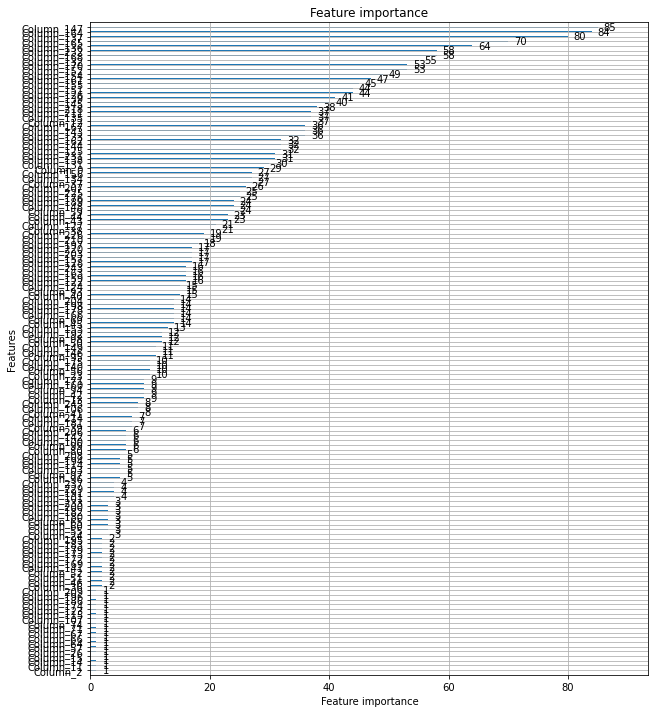

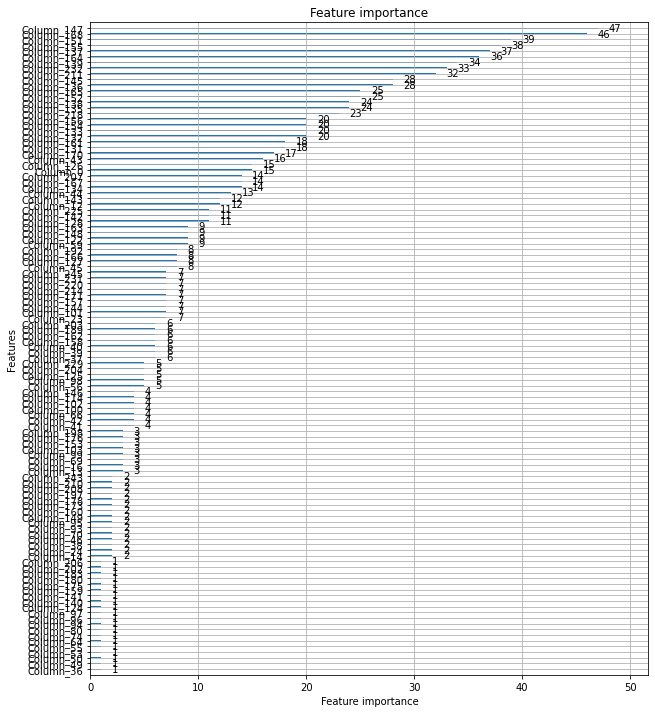

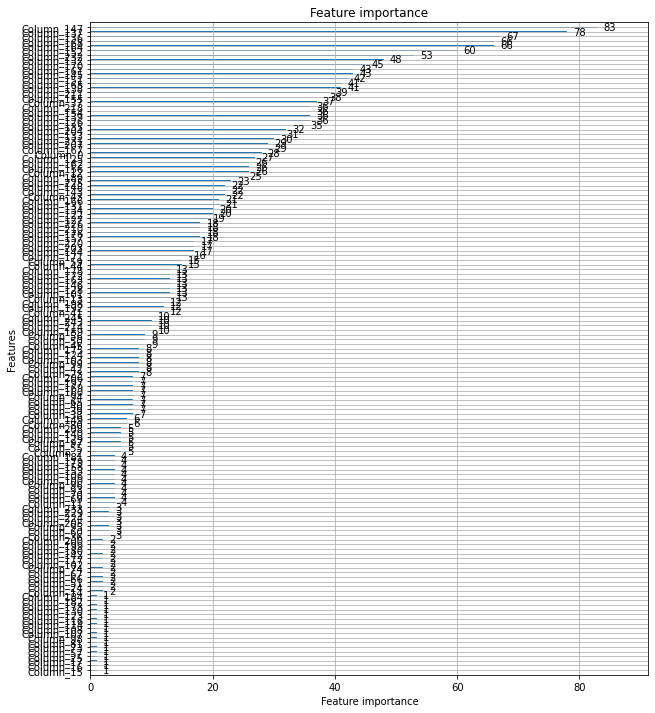

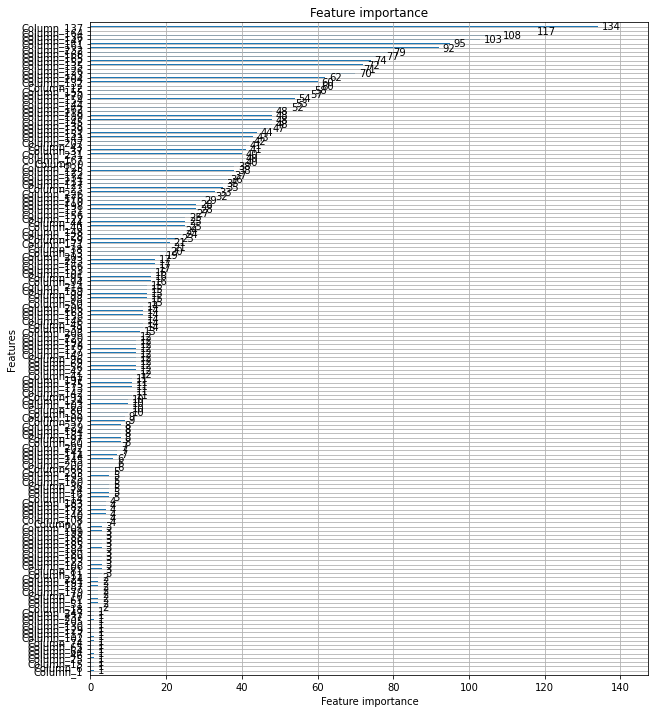

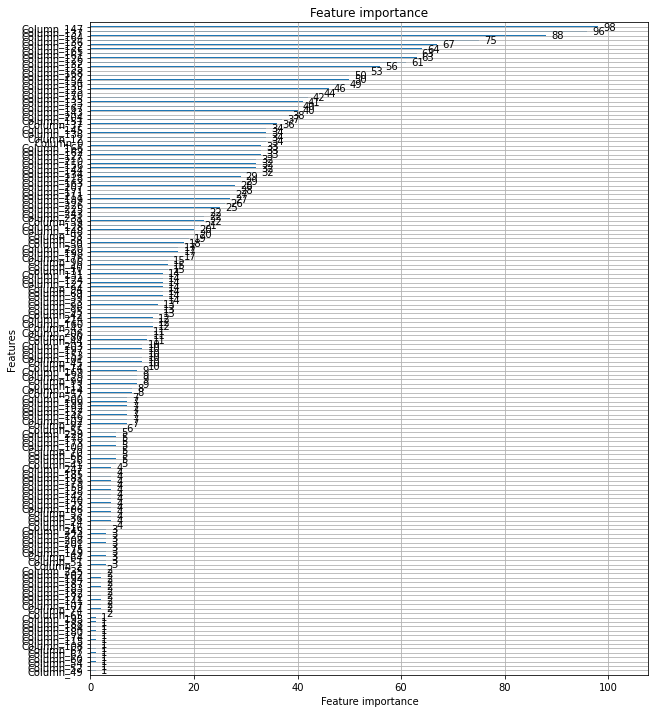

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

for model in models:
  fig, ax = plt.subplots(figsize=(10, 12))
  plot_importance(model, ax=ax)